In [1]:
# encoding = utf-8
# Author: Silk-Road
# Date: 2021-01-05
# Email: swami.liu@outlook.com
# Last modified by: Silk-Road
# Last modified time: 2021-01-06

In [2]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_PKG_SERVER = pkg.juliahub.com
  JULIA_DEPOT_PATH = /Users/swami/.julia:/Applications/JuliaPro-1.5.3-1.app/Contents/Resources/julia/Contents/Resources/julia/local/share/julia:/Applications/JuliaPro-1.5.3-1.app/Contents/Resources/julia/Contents/Resources/julia/share/julia
  JULIA_LOAD_PATH = /Users/swami/.julia/environments/JuliaPro_v1.5.3-1:@:@v#.#:@stdlib


In [4]:
using StatsBase
using Random
using StatsPlots

include("rl_glue.jl")
include("main_agent.jl")
include("ten_arm_env.jl")
include("utils.jl")

argmax (generic function with 1 method)

## Section 1: Greedy Agent

We want to create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with  the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

In [5]:
function argmax(q_values)
    top = -Inf
    ties = []

    for i in 1:length(q_values)
        if q_values[i] > top
            top = q_values[i]
            ties = []
        end
        if q_values[i] == top
            append!(ties, i)
        end
    end
    return sample(ties)
end

# Test `argmax` implementation
test_array  = [0,0,0,0,0,0,0,0,1,0]

@assert argmax(test_array) == 9 "There is something wrong in `argmax` function"


Now we introduce the first part of an RL-Glue agent that you will implement. Here we are going to create a GreedyAgent and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

In [6]:
mutable struct GreedyAgent<:BaseAgent
    last_action
    num_actions
    q_values
    step_size
    epsilon
    initial_value
    arm_count
    current_action
    function GreedyAgent(;last_action=nothing, num_actions = nothing, q_values = nothing,
                   step_size = nothing, epsilon = nothing, current_action = nothing,
                   initial_value=0.0, arm_count=zeros(10))
        agent = new()
        agent.last_action=last_action
        agent.num_actions = num_actions
        agent.q_values = q_values
        agent.step_size = step_size
        agent.epsilon = epsilon
        agent.current_action = current_action
        agent.initial_value = initial_value
        agent.arm_count = arm_count
        agent
    end
end

function agent_init(agent::GreedyAgent; agent_info=Dict())
    agent.num_actions = get(agent_info, "num_actions", 2)
    agent.initial_value = get(agent_info, "initial_value", 0.0)
    agent.q_values = ones(Int(get(agent_info, "num_actions", 2)))*agent.initial_value
    agent.step_size = get(agent_info, "step_size", 0.1)
    agent.epsilon = get(agent_info, "epsilon", 0.0)
    agent.last_action = 0
    return agent
end

function agent_start(agent::GreedyAgent, observation)
    # StatsBase:sample == np.random.choice
    agent.last_action = sample(1:agent.num_actions) # set first action to 0
    return agent.last_action
end

function agent_start(agent::GreedyAgent)
    # StatsBase:sample == np.random.choice
    agent.last_action = sample(1:agent.num_actions) # set first action to 0
    return agent.last_action
end

function agent_step(agent::GreedyAgent, reward, observation)
    # local_action = 0 # choose the action here

    #agent.last_action = sample(0:(agent.num_actions-1))
    current_action = agent.last_action
    agent.arm_count[current_action] = agent.arm_count[current_action] + 1
    agent.q_values[current_action] = agent.q_values[current_action] +
                                        1/agent.arm_count[current_action] *
                                        (reward - agent.q_values[current_action])
    current_action = argmax(agent.q_values)
    agent.last_action = current_action
    return current_action
end


function agent_end(agent::GreedyAgent, reward)
end

function agent_cleanup(agent::GreedyAgent)
end


function agent_message(agent::GreedyAgent, message)
end

agent_message (generic function with 2 methods)

In [7]:
# Test for Greedy Agent Code
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0,0,1.0,0,0]
greedy_agent.arm_count = [0,1,0,0,0]
greedy_agent.last_action = 2 

action = agent_step(greedy_agent, 1,1)
println(action)
println(greedy_agent.q_values)

println("Output:")
println(greedy_agent.q_values)
println("Expected Output:")
println([0, 0.5, 1.0, 0, 0])

@assert action == 3 "Check that you are using argmax to choose the action with the highest value."
@assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0] "Check that you are updating q_values correctly."

3
[0.0, 0.5, 1.0, 0.0, 0.0]
Output:
[0.0, 0.5, 1.0, 0.0, 0.0]
Expected Output:
[0.0, 0.5, 1.0, 0.0, 0.0]


Let's visualize the result. Here we run an experiment using RL-Glue to test our agent. For now, we will set up the experiment code; in future lessons, we will walk you through running experiments so that you can create your own.

In [8]:
# Plot Greedy Result
num_runs = 200                       # The number of times we run the experiment
num_steps = 1000                     # The number of steps each experiment is run
env = Environment                    # The environment to use
agent = GreedyAgent                  # Choose what agent we want to use
agent_info = Dict("num_actions"=>10) # Pass the agent the information it needs
                                     # here it just needs the number of actions (number of arms)
env_info = Dict()
all_averages = []

for i in 1:num_runs
    rl_glue = RLGlue(Environment, GreedyAgent, agent_init_info=agent_info) # Create a new RLGlue  experiment with the env and agent we choose above
    #rl_init(rl_glue, agent_info, env_info)     # Pass RLGlue what it needs to initialize the agent and enviromnet
    rl_start(rl_glue)                          # Start the experiment

    scores = [0.0]
    averages = []
    for j in 1:num_steps
        reward , _, action, _ =rl_step(rl_glue)  # The enviroment and agent take a step and return the reward, and action taken

        append!(scores, [scores[end]+reward])
        append!(averages, [scores[end]/(j+1)])
    end
    append!(all_averages, [averages])
end


In [9]:
greedy_scores = mean(all_averages);

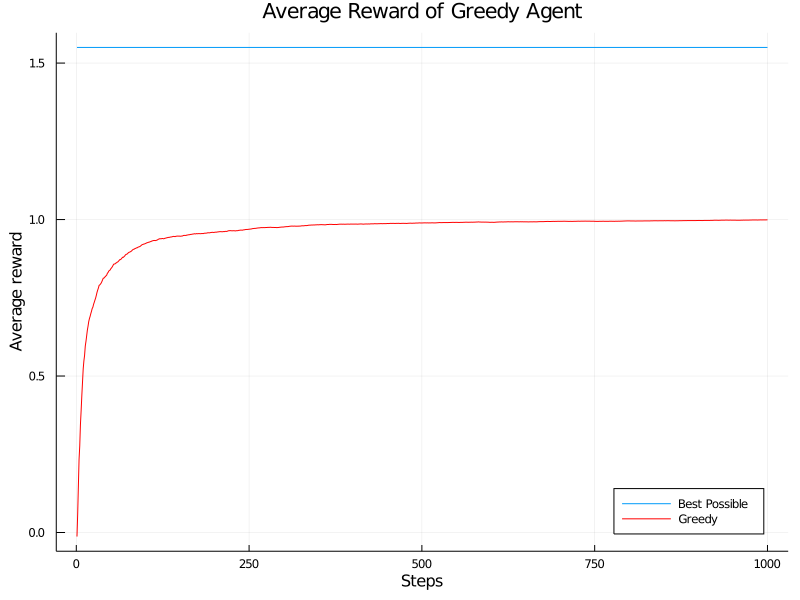

In [10]:
# Initialize
gr(size=(800, 600))
plot([1.55 for _ in 1:num_steps], label = "Best Possible")
plot!(mean(all_averages), colour = :red, xlabel = "Steps", ylabel = "Average reward",
    legend = :bottomright, title = "Average Reward of Greedy Agent", 
    label = "Greedy") 

## Section 2: Epsilon-Greedy Agent

We learned about [another way for an agent to operate](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/tHDck/what-is-the-trade-off), where it does not always take the greedy action. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action really is. If we always choose what we think is the current best action is, we may miss out on taking the true best action, because we haven't explored enough times to find that best action.

Implement an epsilon-greedy agent below. Hint: we are implementing the algorithm from [section 2.4](http://www.incompleteideas.net/book/RLbook2018.pdf#page=52) of the textbook.

In [11]:
mutable struct EpsilonGreedyAgent<:BaseAgent
    last_action
    num_actions
    q_values
    step_size
    epsilon
    initial_value
    arm_count
    current_action
    function EpsilonGreedyAgent(;last_action = nothing, num_actions = nothing, q_values = nothing,
                   step_size = nothing, epsilon = nothing, current_action = nothing,
                   initial_value=0.0, arm_count=zeros(10))
        agent = new()
        agent.last_action=last_action
        agent.num_actions = num_actions
        agent.q_values = q_values
        agent.step_size = step_size
        agent.epsilon = epsilon
        agent.current_action = current_action
        agent.initial_value = initial_value
        agent.arm_count = arm_count
        agent
    end
end

function agent_init(agent::EpsilonGreedyAgent; agent_info=Dict())
    agent.num_actions = get(agent_info, "num_actions", 2)
    agent.initial_value = get(agent_info, "initial_value", 0.0)
    agent.q_values = ones(Int(get(agent_info, "num_actions", 2)))*agent.initial_value
    agent.step_size = get(agent_info, "step_size", 0.1)
    agent.epsilon = get(agent_info, "epsilon", 0.0)
    agent.last_action = 0
    return agent
end



function agent_start(agent::EpsilonGreedyAgent, observation)
    # StatsBase:sample == np.random.choice
    agent.last_action = sample(1:agent.num_actions) # set first action to 0
    return agent.last_action
end

function agent_start(agent::EpsilonGreedyAgent)
    # StatsBase:sample == np.random.choice
    agent.last_action = sample(1:agent.num_actions) # set first action to 0
    return agent.last_action
end

function agent_step(agent::EpsilonGreedyAgent, reward, observation)
#function agent_step(agent::EpsilonGreedyAgent, reward)
    # local_action = 0 # choose the action here
    current_action = agent.last_action
    agent.arm_count[current_action] = agent.arm_count[current_action] + 1
    agent.q_values[current_action] = agent.q_values[current_action] +
                                        1/agent.arm_count[current_action] *
                                        (reward - agent.q_values[current_action])
    rand_num = rand()
    if rand_num < agent.epsilon
        current_action = sample(1:length(agent.q_values))
    else
        current_action = argmax(agent.q_values)
    end
    agent.last_action = current_action
    return current_action
end


function agent_end(agent::EpsilonGreedyAgent, reward)
end

function agent_cleanup(agent::EpsilonGreedyAgent)
end


function agent_message(agent::EpsilonGreedyAgent, message)
end

agent_message (generic function with 3 methods)

In [12]:
# test
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0,0,1.0,0,0]
e_greedy_agent.arm_count = [0,1,0,0,0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 2
e_greedy_agent.epsilon = 0.5
action = agent_step(e_greedy_agent,1,0)
println(e_greedy_agent.q_values)

[0.0, 0.5, 1.0, 0.0, 0.0]


Notice how much better the epsilon-greedy agent did. Because we occasionally choose a random action we were able to find a better long term policy. By acting greedily before our value estimates are accurate, we risk settling on a suboptimal action.

In [14]:
# Plot Epsilon greedy results and greedy results

# Plot Greedy Result
num_runs = 200                       # The number of times we run the experiment
num_steps = 1000                     # The number of steps each experiment is run
epsilon = 0.1
env = Environment                    # The environment to use
agent = EpsilonGreedyAgent                  # Choose what agent we want to use
agent_info = Dict("num_actions"=>10, "epsilon"=>epsilon) # Pass the agent the information it needs
                                     # here it just needs the number of actions (number of arms)
env_info = Dict()
all_averages = []

for i in 1:num_runs
    rl_glue = RLGlue(env, agent, agent_init_info = agent_info) # Create a new RLGlue  experiment with the env and agent we choose above
    #rl_init(rl_glue, agent_info, env_info)     # rl_init has merge into the definition of RLGlue
    rl_start(rl_glue)                          # Start the experiment

    scores = [0.0]
    averages = []
    for j in 1:num_steps
        reward , _, action, _ =rl_step(rl_glue)  # The enviroment and agent take a step and return the reward, and action taken

        append!(scores, [scores[end]+reward])
        append!(averages, [scores[end]/(j+1)])
    end
    append!(all_averages, [averages])
end

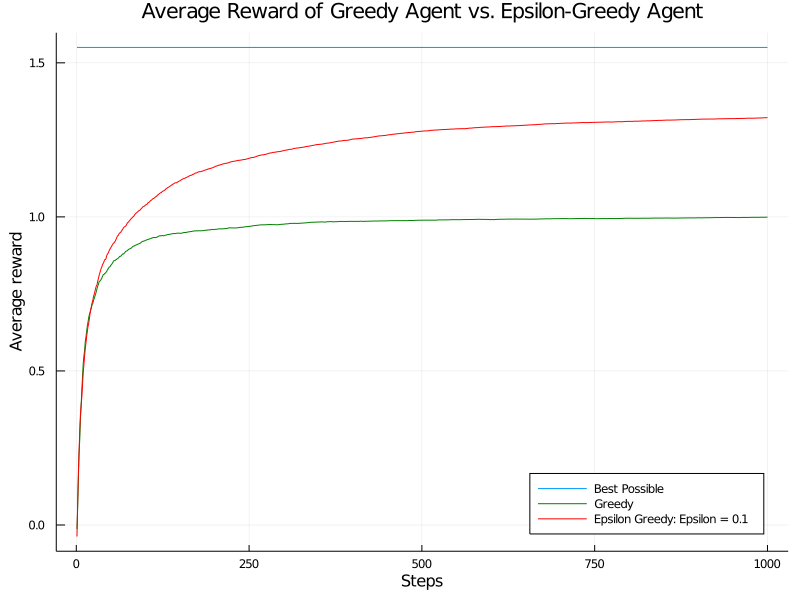

In [15]:
# Initialize
gr(size=(800, 600))
plot([1.55 for _ in 1:num_steps], label = "Best Possible")
plot!(greedy_scores, label = "Greedy", colour=:green)
plot!(mean(all_averages), colour = :red, xlabel = "Steps", ylabel = "Average reward",
    legend = :bottomright, title = "Average Reward of Greedy Agent vs. Epsilon-Greedy Agent", 
    label = "Epsilon Greedy: Epsilon = 0.1") 

## 1.2 Averaging Multiple Runs

Did you notice that we averaged over 2000 runs? Why did we do that?

To get some insight, let's look at the results of two individual runs by the same agent.

In [16]:
for i in 1:num_runs
    rl_glue = RLGlue(env, agent, agent_init_info = agent_info) # Create a new RLGlue  experiment with the env and agent we choose above
    rl_start(rl_glue) # Start the experiment

    scores = [0.0]
    averages = []
    for i in 1:num_steps
        reward , _, action, _ =rl_step(rl_glue)  # The enviroment and agent take a step and return the reward, and action taken
        append!(scores, [scores[end]+reward])
        append!(averages, [scores[end]/(i+1)])
    end
    append!(all_averages, [averages])
end

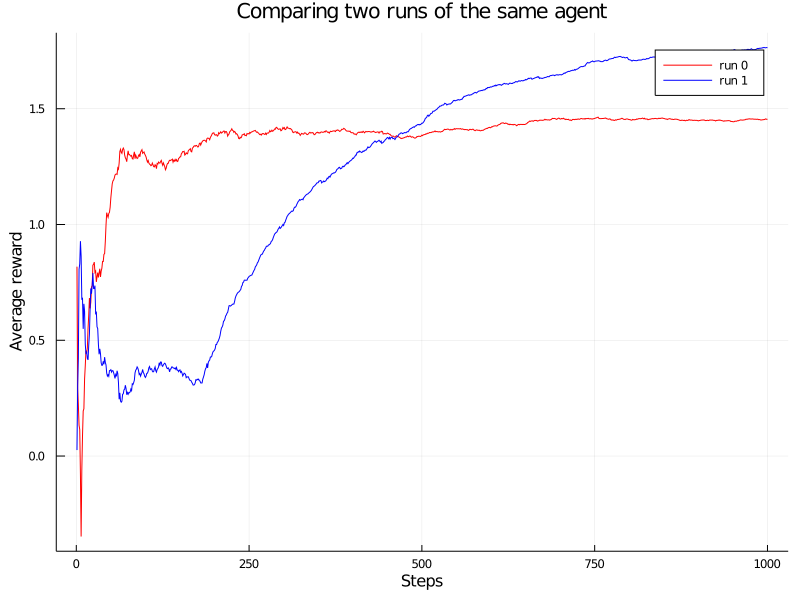

In [17]:
# Plot runs of e-greedy agent
gr(size=(800, 600))
plot()
env = Environment
agent = EpsilonGreedyAgent
agent_info = Dict("num_actions"=> 10, "epsilon"=> 0.1)
env_info = Dict()
all_averages = []

num_steps = 1000

for run in [0, 1]
    Random.seed!(run) # Here we set the seed so that we can compare two different runs
    rl_glue = RLGlue(env, agent, agent_init_info = agent_info, env_init_info=env_info)
    rl_start(rl_glue)

    scores = [0.0]
    averages = []
    for i in 1:num_steps
        reward, state, action, is_terminal = rl_step(rl_glue)
        append!(scores, [scores[end] + reward])
        append!(averages, [scores[end] / (i + 1)])
    end
    #append!(all_averages, [averages])
    plot!(averages, colour=Symbol(["red","blue"][run+1]), label = "run $run")
end
plot!(title = "Comparing two runs of the same agent",
    xlabel = "Steps", ylabel = "Average reward")


Notice how the two runs were different? But, if this is the exact same algorithm, why does it behave differently in these two runs?

The answer is that it is due to randomness in the environment and in the agent. Depending on what action the agent randomly starts with, or when it randomly chooses to explore, it can change the results of the runs. And even if the agent chooses the same action, the reward from the environment is randomly sampled from a Gaussian. The agent could get lucky, and see larger rewards for the best action early on and so settle on the best action faster. Or, it could get unlucky and see smaller rewards for best action early on and so take longer to recognize that it is in fact the best action.

To be more concrete, let’s look at how many times an exploratory action is taken, for different seeds. 

In [18]:
println("Random Seed 1")
Random.seed!(1)
for _ in 1:15
    if rand() < 0.1
        println("Exploratory Action")
    end
end
   
println()
println()

println("Random Seed 2")
Random.seed!(2)
for _ in 1:15
    if rand() < 0.1
        println("Exploratory Action")
    end
end

Random Seed 1
Exploratory Action


Random Seed 2
Exploratory Action


With the first seed, we take an exploratory action three times out of 15, but with the second, we only take an exploratory action once. This can significantly affect the performance of our agent because the amount of exploration has changed significantly.

To compare algorithms, we therefore report performance averaged across many runs. We do this to ensure that we are not simply reporting a result that is due to stochasticity, as explained [in the lectures](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/PtVBs/sequential-decision-making-with-evaluative-feedback). Rather, we want statistically significant outcomes. We will not use statistical significance tests in this course. Instead, because we have access to simulators for our experiments, we use the simpler strategy of running for a large number of runs and ensuring that the confidence intervals do not overlap. 

## Section 3: Comparing values of epsilon

Can we do better than an epsilon of 0.1? Let's try several different values for epsilon and see how they perform. We try different settings of key performance parameters to understand how the agent might perform under different conditions.

Below we run an experiment where we sweep over different values for epsilon:

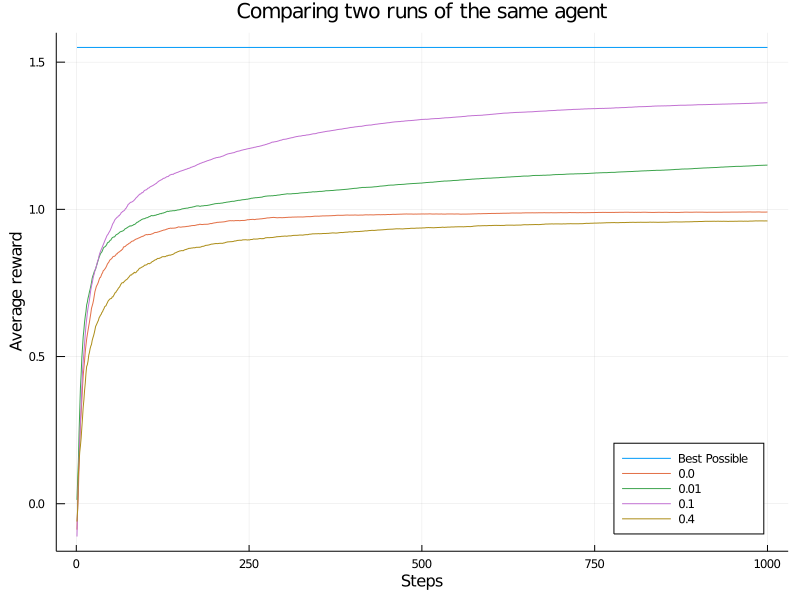

In [19]:
gr(size=(800, 600))
plot([1.55 for _ in 1:num_steps], label = "Best Possible", 
    title = "Comparing two runs of the same agent",
    xlabel = "Steps", ylabel = "Average reward")
epsilons = [0.0, 0.01, 0.1, 0.4]
n_q_values = []
n_averages = []
n_best_actions = []
num_steps = 1000
num_runs = 200

for epsilon in epsilons
    all_averages = []

    for run in 1:num_runs
        agent = EpsilonGreedyAgent
        env = Environment
        agent_info = Dict("num_actions"=>10, "epsilon"=>epsilon)
        env_info = Dict("random_seed"=>run)
        rl_glue = RLGlue(env, agent, agent_init_info = agent_info, env_init_info=env_info)
        rl_start(rl_glue)

        best_arm = argmax(rl_glue.environment.arms)

        scores = [0.0]
        averages = []
        best_action_chosen = []

        for i in 1:num_steps
            reward, state, action, is_terminal = rl_step(rl_glue)
            append!(scores, [scores[end]+reward])
            append!(averages, [scores[end]/(i+1)])
            if action == best_arm
                append!(best_action_chosen, [1])
            else
                append!(best_action_chosen, [0])
            end
            if epsilon==0.1 && run == 1
                append!(n_q_values, [copy(rl_glue.agent.q_values)])
            end
        end

        if epsilon == 0.1
            append!(n_averages, [averages])
            append!(n_best_actions, [best_action_chosen])
        end
        append!(all_averages, [averages])
    end
    plot!(mean(all_averages), label = epsilon)
end
plot!(legend = :bottomright)


Why did 0.1 perform better than 0.01?

If exploration helps why did 0.4 perform worse that 0.0 (the greedy agent)?

Think about these and how you would answer these questions. They are questions in the practice quiz. If you still have questions about it, retake the practice quiz.

## Section 4: The Effect of Step Size

In Section 1 of this assignment, we decayed the step size over time based on action-selection counts. The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method? 

To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. You will change the update to have a constant step size instead of using the 1/N(A) update.

In [20]:
mutable struct EpsilonGreedyAgentConstantStepsize<:BaseAgent
    last_action
    num_actions
    q_values
    step_size
    epsilon
    initial_value
    arm_count
    current_action
    function EpsilonGreedyAgentConstantStepsize(;last_action = nothing, num_actions = nothing,
                   q_values = nothing, step_size = nothing, epsilon = nothing,
                   current_action = nothing, initial_value=0.0, arm_count=zeros(10))
        agent = new()
        agent.last_action=last_action
        agent.num_actions = num_actions
        agent.q_values = q_values
        agent.step_size = step_size
        agent.epsilon = epsilon
        agent.current_action = current_action
        agent.initial_value = initial_value
        agent.arm_count = arm_count
        agent
    end
end

function agent_init(agent::EpsilonGreedyAgentConstantStepsize; agent_info=Dict())
    agent.num_actions = get(agent_info, "num_actions", 2)
    agent.initial_value = get(agent_info, "initial_value", 0.0)
    agent.q_values = ones(Int(get(agent_info, "num_actions", 2)))*agent.initial_value
    agent.step_size = get(agent_info, "step_size", 0.1)
    agent.epsilon = get(agent_info, "epsilon", 0.0)
    agent.last_action = 0
    return agent
end

function agent_start(agent::EpsilonGreedyAgentConstantStepsize, observation)
    # StatsBase:sample == np.random.choice
    agent.last_action = sample(1:agent.num_actions) # set first action to 0
    return agent.last_action
end

function agent_start(agent::EpsilonGreedyAgentConstantStepsize)
    # StatsBase:sample == np.random.choice
    agent.last_action = sample(1:agent.num_actions) # set first action to 0
    return agent.last_action
end

function agent_step(agent::EpsilonGreedyAgentConstantStepsize, reward, observation)
#function agent_step(agent::EpsilonGreedyAgent, reward)
    # local_action = 0 # choose the action here
    rand_num = rand()
    if rand_num < agent.epsilon
        current_action = sample(1:length(agent.q_values))
    else
        current_action = argmax(agent.q_values)
    end

    agent.arm_count[agent.last_action] = agent.arm_count[agent.last_action] + 1
    agent.q_values[agent.last_action] = agent.q_values[agent.last_action] +
                                        agent.step_size *
                                        (reward - agent.q_values[agent.last_action])

    agent.last_action = current_action
    return current_action
end


function agent_end(agent::EpsilonGreedyAgentConstantStepsize, reward)
end

function agent_cleanup(agent::EpsilonGreedyAgentConstantStepsize)
end


function agent_message(agent::EpsilonGreedyAgentConstantStepsize, message)
end

for step_size in [0.01, 0.1, 0.5, 1.0]
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0,0,1.0,0,0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = agent_step(e_greedy_agent,1,0)
    println(e_greedy_agent.q_values)
end

[0.01, 0.0, 1.0, 0.0, 0.0]
[0.1, 0.0, 1.0, 0.0, 0.0]
[0.5, 0.0, 1.0, 0.0, 0.0]
[1.0, 0.0, 1.0, 0.0, 0.0]


In [21]:
using Plots

In [22]:
epsilon = 0.1
num_steps = 1000
num_runs = 200

gr(size=(800, 600))
l = @layout [a b; c d]


step_sizes = [0.01, 0.1, 0.5, 1.0]
q_values = Dict(step_size => [] for step_size in step_sizes)
true_values = Dict(step_size => Nothing for step_size in step_sizes)
best_actions = Dict(step_size => [] for step_size in step_sizes)

p = []

for step_size in step_sizes
    all_averages = []
    for run in 1:num_runs
        env = Environment
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = Dict("num_actions"=>10, "epsilon"=>epsilon,
                          "step_size"=>step_size, "initial_value"=>0.0)
        env_info = Dict("random_seed"=>run)

        rl_glue = RLGlue(env, agent, agent_init_info = agent_info, env_init_info = env_info)
        rl_start(rl_glue)

        best_arm = argmax(rl_glue.environment.arms)
        scores = [0.0]
        averages = []

        if run==0
            true_values[step_size] = copy(rl_glue.environment.arms)
        end

        best_action_chosen = []
        for i in 1:num_steps
            reward, state, action, is_terminal = rl_step(rl_glue)
            append!(scores, [scores[end] + reward])
            append!(averages, [scores[end]/(i+1)])
            if action == best_arm
                append!(best_action_chosen, [1])
            else
                append!(best_action_chosen, [0])
            end
            if run == 0
                append!(q_values[step_size], [copy(rl_glue.agent.q_values)])
            end
        end
        append!(best_actions[step_size], [best_action_chosen])

    end
    #println(mean(best_actions[step_size]), "\n")
    tmp_p = plot(mean(best_actions[step_size]))
    append!(p, [tmp_p])
end


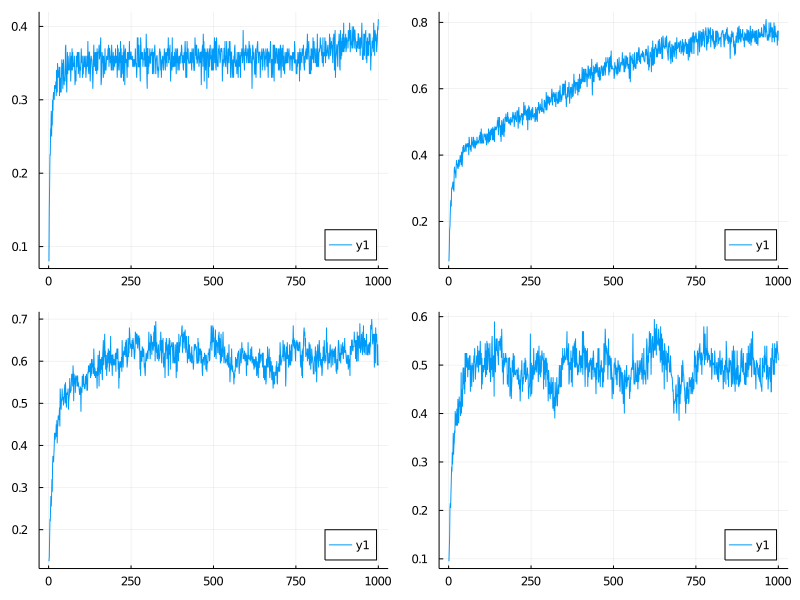

In [23]:
plot(p[1], p[2],p[3],p[4], layout=l,legend = :bottomright)

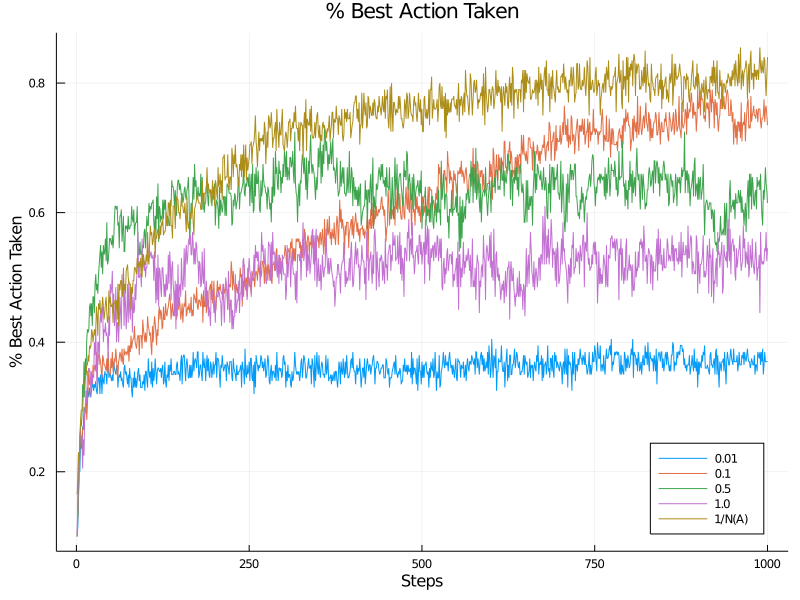

In [24]:

epsilon = 0.1
num_steps = 1000
num_runs = 200

gr(size=(800, 600))

step_sizes = [0.01, 0.1, 0.5, 1.0]
q_values = Dict(step_size => [] for step_size in step_sizes)
true_values = Dict(step_size => [] for step_size in step_sizes)
best_actions = Dict(step_size => [] for step_size in step_sizes)

plot()
for step_size in step_sizes
    all_averages = []
    for run in 1:num_runs
        env = Environment
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = Dict("num_actions"=>10, "epsilon"=>epsilon,
                          "step_size"=>step_size, "initial_value"=>0.0)
        env_info = Dict("random_seed"=>run)

        rl_glue = RLGlue(env, agent, agent_init_info = agent_info, env_init_info = env_info)
        rl_start(rl_glue)

        best_arm = argmax(rl_glue.environment.arms)
        scores = [0.0]
        averages = []

        if run==1 
            true_values[step_size] = copy(rl_glue.environment.arms)
        end

        best_action_chosen = []
        for i in 1:num_steps
            reward, state, action, is_terminal = rl_step(rl_glue)
            append!(scores, [scores[end] + reward])
            append!(averages, [scores[end]/(i+1)])
            if action == best_arm
                append!(best_action_chosen, [1])
            else
                append!(best_action_chosen, [0])
            end
            if run == 1 
                append!(q_values[step_size], [copy(rl_glue.agent.q_values)])
            end
        end
        append!(best_actions[step_size], [best_action_chosen])

    end
    plot!(mean(best_actions[step_size]), label = step_size)
end
plot!(mean(n_best_actions), label = "1/N(A)")
plot!(title="% Best Action Taken", xlabel="Steps", ylabel="% Best Action Taken", legend = :bottomright)


Notice first that we are now plotting the amount of time that the best action is taken rather than the average reward. To better  understand the performance of an agent, it can be useful to measure specific behaviors, beyond just how much reward is accumulated. This measure indicates how close the agent’s behaviour is to optimal.

It seems as though 1/N(A) performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?

Let's dig into this further below. Let’s plot how well each agent tracks the true value, where each agent has a different step size method. You do not have to enter any code here, just follow along.

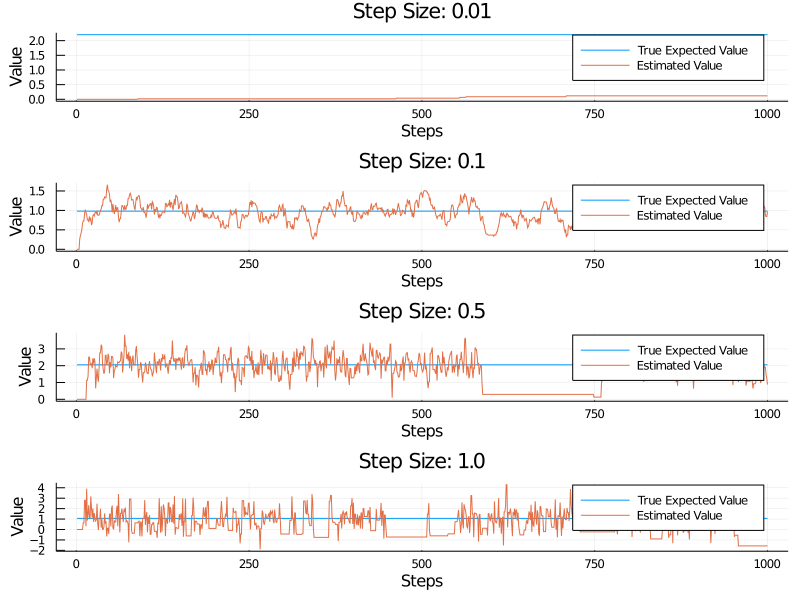

In [25]:
# Plot various step sizes and estimates
largest = 0
l = @layout [a; b; c; d]
p = []
num_steps = 1000
for step_size in step_sizes
    gr(size=(800, 600))
    largest = argmax(true_values[step_size])
    tmp_p = plot([true_values[step_size][largest] for _ in 1:num_steps], title = "Step Size: $step_size",
        label = "True Expected Value")
    tmp_p = plot!([q_values[step_size][i][largest] for i in 1:num_steps], label = "Estimated Value")
    append!(p, [tmp_p])
end

plot(p[1],p[2],p[3],p[4], layout = l)
plot!(xlabel = "Steps", ylabel = "Value")

These plots help clarify the performance differences between the different step sizes. A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is.  A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.


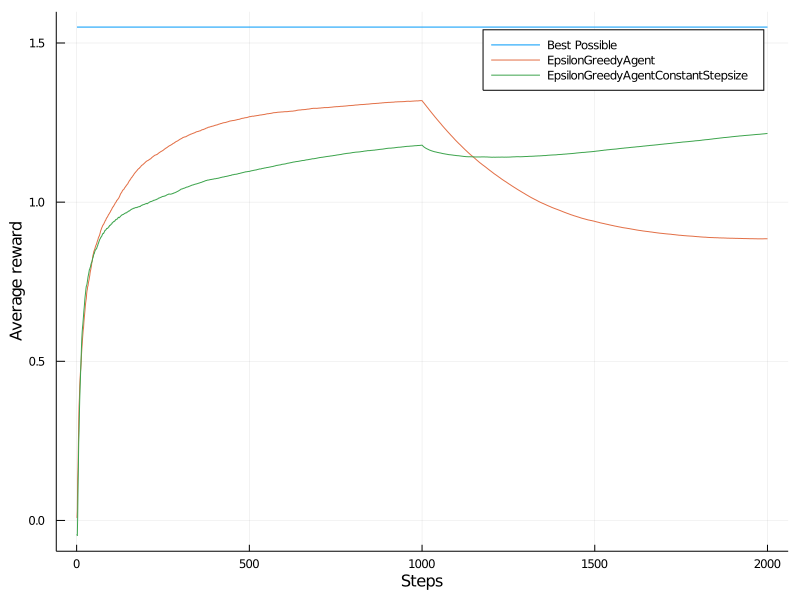

In [26]:
epsilon = 0.1 
num_steps = 2000 
num_runs = 200 
step_size = 0.1 

gr(size=(800, 600))
plot([1.55 for _ in 1:num_steps], label = "Best Possible", 
    xlabel = "Steps", ylabel = "Average reward")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]
    all_averages = []
    for run in 1:num_runs
        agent_info = Dict("num_actions"=>10, "epsilon"=>epsilon, "step_size"=>step_size)
        env_info = Dict("random_seed"=>run)

        rl_glue = RLGlue(env, agent, agent_init_info = agent_info, env_init_info = env_info)
        rl_start(rl_glue)

        scores = [0.0]
        averages = [] 

        for i in 1:num_steps 
            reward, state, action, is_terminal = rl_step(rl_glue) 
            append!(scores, [scores[end] + reward])
            append!(averages, [scores[end] / (i+1)])
            if i == 1000 
                rl_glue.environment.arms = randn(10)
            end 
        end 
        append!(all_averages, [averages])
    end 
    plot!(mean(all_averages), label = agent)
end 
plot!()

Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?

Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error. That is a very tiny adjustment and it will take a long time for it to get to the true value.

The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.

These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment. Nonstationarity---and the related concept of partial observability---is a common feature of reinforcement learning problems and when learning online.  